# Estimation of the Kappa 2 test statistic

Ref. Sansó et al. *Testing for Changes in the Unconditional Variance of Financial Time Series*, Chapter 3
<br>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Specific for KAPPA2
import statsmodels.api as sm

In [2]:
# Plot styling
plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('ticks')
sns.set_context('poster')

**Datasets**

In [3]:
# The IBM test set (ref. Inclan & Tiao, 1994 - DOI: 10.2307/2290916)
# 17th May 1961 – 2nd November 1962
#ibm = [460,457,452,459,462,459,463,479,493,490,492,498,499,497,496,490,489,478,487,491,487,482,479,478,479,477,479,475,479,476,476,478,479,477,476,475,475,473,474,474,474,465,466,467,471,471,467,473,481,488,490,489,489,485,491,492,494,499,498,500,497,494,495,500,504,513,511,514,510,509,515,519,523,519,523,531,547,551,547,541,545,549,545,549,547,543,540,539,532,517,527,540,542,538,541,541,547,553,559,557,557,560,571,571,569,575,580,584,585,590,599,603,599,596,585,587,585,581,583,592,592,596,596,595,598,598,595,595,592,588,582,576,578,589,585,580,579,584,581,581,577,577,578,580,586,583,581,576,571,575,575,573,577,582,584,579,572,577,571,560,549,556,557,563,564,567,561,559,553,553,553,547,550,544,541,532,525,542,555,558,551,551,552,553,557,557,548,547,545,545,539,539,535,537,535,536,537,543,548,546,547,548,549,553,553,552,551,550,553,554,551,551,545,547,547,537,539,538,533,525,513,510,521,521,521,523,516,511,518,517,520,519,519,519,518,513,499,485,454,462,473,482,486,475,459,451,453,446,455,452,457,449,450,435,415,398,399,361,383,393,385,360,364,365,370,374,359,335,323,306,333,330,336,328,316,320,332,320,333,344,339,350,351,350,345,350,359,375,379,376,382,370,365,367,372,373,363,371,369,376,387,387,376,385,385,380,373,382,377,376,379,386,387,386,389,394,393,409,411,409,408,393,391,388,396,387,383,388,382,384,382,383,383,388,395,392,386,383,377,364,369,355,350,353,340,350,349,358,360,360,366,359,356,355,367,357,361,355,348,343,330,340,339,331,345,352,346,352,357]
#ibm = np.array(ibm, dtype='int64') # Cast as int64 to avoid overflow in kappa1
#ibm_returns = np.log(ibm) - np.log(np.roll(ibm, 1))
#ibm_returns = np.delete(ibm_returns, (0), axis=0)
#data = ibm_returns

In [4]:
# The SANSO sets
# IMPORTANT ---- FOLLOW THESE STEPS TO GET clean 1d np.array as input
df = pd.read_csv('sanso_sets.csv') # Contains FTSE / HAN / NIK / SP
ftse = df['FTSE']
ftse = ftse.dropna()
data = ftse.values

**Plot of the data used for analysis**

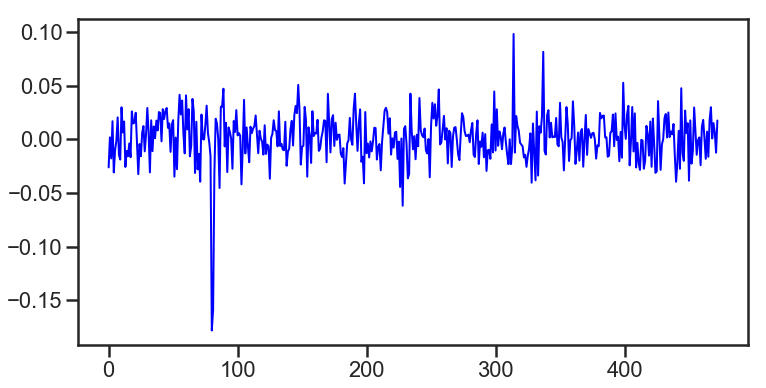

In [5]:
sns.lineplot(data=data, color='blue', lw=2, legend=False)

**Functions that the Kappa 2 function depend on**
<br>
The provided example of how to run the analysis have some direct requirements but most of the functions are implemented completely. These functions are primarily from [variance.src](https://github.com/fokep/Sanso_et_al-ICSS/blob/master/icss/variance.src) but also one external (from [Statsmodels](https://www.statsmodels.org/), and one implementation of a GAUSS function I could not immediately replace.

In [6]:
def autocov(data):
    """Instead of adopting the Sanso GAUSS acov function,
        this is just using Statsmodels to calc autocovariance 1D

    """
    output = sm.tsa.stattools.acovf(data)
    
    return output

def seqa(S, H, N):
    """Creates an additive sequence

    an implementation of the SEQA function in GAUSS:
        Y_j = S + (J - 1) H

    Example: seqa(2.5, 0.25, 10) will return a 
        10 x 1 array with 2.5, 2.75, 3, 3.25 etc

    Input:
        S - Starting point (int / float)
        H - Added component (int / float)
        N - Length of sequence (int)

    """
    stop = ((N-1) * H) + S
    seqa = np.linspace(S, stop, N)
    
    return seqa

def qs(T, m):
    """Calculates Quadratic Spectral kernel

    Adapted from Sanso GAUSS code:
    https://github.com/fokep/Sanso_et_al-ICSS/blob/1826ebb5381528a80559ffd2b2e57eb3ab91e238/icss/variance.src#L321
    
    Input:
        T - sample size (int)
        m - bandwidth (int)

    Output:
        np.array of length T

    """
    pi = np.pi
    sin = np.sin
    cos = np.cos

    if m > 0:
        j = seqa(1, 1, T-1)
        j = j/m

        kern = (25/(12 * (pi**2) * (j**2)))  \
             * ((sin(1.2 * pi * j)           \
             / (1.2 * pi * j))               \
             - (cos(1.2 * pi * j)))
    
    elif m == 0:
        kern = np.zeros(T-1)

    else:
        print('wrong bandwidth selection')

    kern = np.concatenate([[1], kern])

    return kern

def bartlett(T, m):
    """Calculates Bartlett kernel

    Adapted from Sanso GAUSS code:
    https://github.com/fokep/Sanso_et_al-ICSS/blob/1826ebb5381528a80559ffd2b2e57eb3ab91e238/icss/variance.src#L287

    Input:
        T - sample size (int)
        m - bandwidth (int)

    Output:
        np.array of length T.

    """
    j = seqa(0, 1, T)
    kern = (1-j /(m+1))
    kern = abs(kern * (kern>0)) # Used abs() to avoid -0.0

    return kern

def lagsel(kerntype, acov, n):
    """Calculates the lag selection

    Adapted from Sanso GAUSS code:
    https://github.com/fokep/Sanso_et_al-ICSS/blob/1826ebb5381528a80559ffd2b2e57eb3ab91e238/icss/variance.src#L366

    Input:
        kerntype - 0 for Bartlett, 1 for Quadratic Spectral
        acov     - array containing the result from the autocovariance function
        n        - bandwidth parameter (int)

    """
    if kerntype not in (0, 1):
        print('Wrong input of kernel choice')

    if n > 0:
        t = len(acov)
        j = 2 * np.ones(n+1)
        j[0] = 1

        if len(acov) < n+1:
            s0 = len(acov)
            print('rows acov: {}'.format(acov))
            print('n: {}'.format(n))
        
        s0 = np.dot(np.transpose(j), acov[0:n+1])
        # Procedure for bartlett kernel
        if kerntype == 0:
            j = 2 * seqa(0, 1, n+1)
            s1 = np.dot(np.transpose(j), acov[0:n+1])
            gam = 1.1447 * (((s1 / s0)**2)**(1/3))
            m = np.concatenate([[[t], np.trunc((gam * (t**(1/3))))]])
            m = m.min()
        # Procedure for QS kernel
        if kerntype == 1:
            j = 2 * (seqa(0, 1, n+1)**2)
            s2 = np.dot(np.transpose(j), acov[0:n+1])
            gam = 1.3221 * (((s2 / s0)**2)**(1/5))
            m = np.concatenate([[t], [(gam * (t**(1/5)))]]).min()
        
    elif n == 0:
        m = 0

    else:
        print('wrong bandwidth choice')
    
    return m

def lvar(x, kernel, auto, n):
    """Calculate the longrun variance estimate
    
    Adapted from Sanso GAUSS code:
    https://github.com/fokep/Sanso_et_al-ICSS/blob/1826ebb5381528a80559ffd2b2e57eb3ab91e238/icss/variance.src#L222

    Input:
        x       - the data vector
        kernel  - 0 for bartlett, 1 for QS
        auto    - 0 for manual proc, 1 for auto
        n       - bandwidth parameter
            (initial bandwidth estimated with NB or NQS procedure???)???
            Sanso use 4?
            
    """
    T = len(x)
    acov = autocov(x)
    # cri part
    if auto == 0:
        m = n
    elif auto == 1:
        if len(acov) < n+1:
            m = len(acov)
        else:
            m = lagsel(kernel, acov, n)
    else:
        print('wrong lag selection variable: cri')
    # kernel part
    if kernel == 0:
        kern = bartlett(T, m)
    elif kernel == 1:
        kern = qs(T, m)
    else:
        print('wrong kernel selection variable: kernel')
    
    k = 2 * np.ones(T)
    k[0] = 1
    lr = np.dot(np.transpose(k), (acov * kern))

    return lr

# The function below is included but I have not yet figured out where it should be used
# input for LAGSEL procedure or maybe lvar
# the value passed from kappa2 is default to 4
def nb_nqs(kernel_type, sample_size, start_param=4):
    """Calculates bandwidth parameter for input to LAGSEL procedure

    Adapted from Sanso GAUSS code (merge of Procedures Nb and Nqs)
        refers to 
    Sequence based on Newey and West (1994), table IIC, page 641.

    Input:
        kernel_type - 0 for Bartlett, 1 for QS
        sample_size - length of time series being examined
        start_param - "parameter chosen by user" :-P (default to 4)

    Output:
        n   - bandwidth param

    """
    T = sample_size
    x = start_param

    if kernel_type == 0:
        n = np.trunc(x*(T/100)**(2/9))
    elif kernel_type == 1:
        n = np.trunc(x*(T/100)**(2/25))
    else:
        print('kernel type is wrong')
    return n

**The Kappa 2 test calculation**
<br>
GAUSS [source](https://github.com/fokep/Sanso_et_al-ICSS/blob/40d14f93a1289a88781f6f75d416937aca890fd4/icss/icss.src#L379)

In [7]:
def kappa2(data):
    """Calculates the Kappa 2 test value and position
            Adapted from Sanso GAUSS code
    
    Input:
        data    -- 1D numpy array with time series data
    
    Output:
        Array containing
            [0] Gk_plot -- plot values
            [1] Gk_max  -- Kappa 2 - the test value (supremum of |Gk_plot|)
            [2] k_star  -- position of Gk_max in array
        
    """
    # Precur
    Ck = np.cumsum(data**2)              # make 1d-array with cumsums of data^2
    CT = Ck[-1]                          # grab the last value off Ck
    T = len(data)                        # get the length of the time-series
    ks = np.arange(1, (T+1))             # make 1d-array with index from (1:T)
    # This is kept from kappa1
    s2 = CT / T
    # This is new local
    e2 = data**2 - np.ones(T)*s2
    # This is from outside function lvar
    c = np.sqrt(lvar(e2, 1, 1, 4))
        
    # Main
    Gk = (Ck - ks*s2)/c
    
    # Output
    Gk_plot = (1/np.sqrt(T)) * Gk        # For plotting
    Gk_max  = np.amax(abs(Gk_plot))      # For test against critical value
    k_star  = np.argmax(abs(Gk))         # For slicing
    
    return Gk_plot, Gk_max, k_star

**Call of the Kappa 2 function**
<br>
The test value and the position of it printed below

In [8]:
result = kappa2(data)

print('Test value: {}'.format(result[1], result[2]))
print('Position: {}'.format(result[2]))

Test value: 0.9319240949942222
Position: 89


**Plot of result**
<br>
Red vertical line indicating position of value

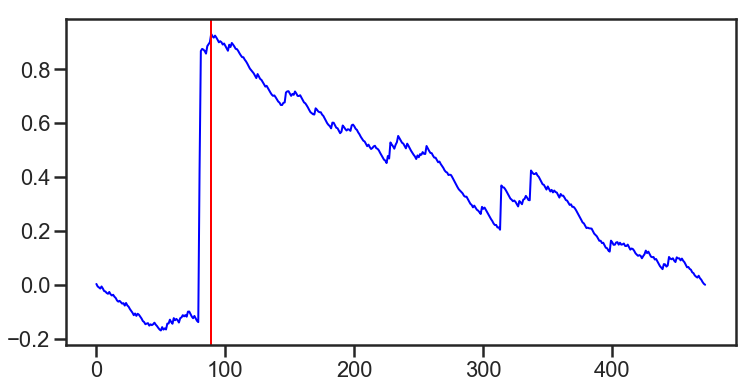

In [9]:
sns.lineplot(data=result[0], color='blue', lw=2, legend=False)
plt.axvline(x=result[2], color='red', lw=2)